In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import transformers
import bitsandbytes as bnb
import networkx as nx

random_state = 1

In [2]:
def euclid(list1, list2):
    return sum((p-q)**2 for p, q in zip(list1, list2)) ** .5

In [3]:
with open('df_policies_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)
df

,name,text,Level,document_name,Type,embeddings
0,Category,ACCOUNT INFORMATION,None,Fitbit.txt,Closed,"[1.376953125, -1.1220703125, 1.982421875, 1.12..."
1,SubCategory,your name,None,Fitbit.txt,Closed,"[0.276123046875, 0.7734375, 0.53076171875, 1.2..."
2,SubCategory,email address,None,Fitbit.txt,Closed,"[1.5146484375, -0.07098388671875, 0.3347167968..."
3,SubCategory,password,None,Fitbit.txt,Closed,"[0.436279296875, -0.021484375, 0.6201171875, -..."
4,SubCategory,date of birth,None,Fitbit.txt,Closed,"[0.5732421875, -1.681640625, -0.114990234375, ..."
...,...,...,...,...,...,...
4113,Category,your contact information,None,Snapchat.txt,Closed,"[1.708984375, -0.94384765625, 0.984375, 0.6762..."
4114,SubCategory,information from third parties,None,Snapchat.txt,Open,"[0.6962890625, -1.0859375, 0.611328125, 0.6069..."
4115,cat,"Or, if you provide us with your contact inform...",2,Snapchat.txt,None,"[0.485107421875, -2.080078125, 0.92724609375, ..."
4116,cat,"Other Information, With Your Permission",2,Snapchat.txt,None,"[0.6630859375, -1.1650390625, 0.44580078125, 1..."


In [4]:
validation_set = ['X_Twitter.txt', 'LinkedIn.txt', 'Zoom.txt', 'Fitbit.txt', 'Western Union.txt', 'Ubisoft.txt']
test_set =  ['Yahoo.txt', 'TikTok.txt', 'MySugr.txt', 'Deliveroo.txt', 'Paypal.txt', 'AdobePhotoshop.txt']
nontrain_set = validation_set + test_set
nontrain_set

['X_Twitter.txt',
 'LinkedIn.txt',
 'Zoom.txt',
 'Fitbit.txt',
 'Western Union.txt',
 'Ubisoft.txt',
 'Yahoo.txt',
 'TikTok.txt',
 'MySugr.txt',
 'Deliveroo.txt',
 'Paypal.txt',
 'AdobePhotoshop.txt']

In [5]:
df_train = df[~df.document_name.isin(nontrain_set)]
df_train = df_train.dropna(subset = ['Level'])
df_train

,name,text,Level,document_name,Type,embeddings
170,cat,"Personal Identifiers\ta real name, birth date,...",1,Kardia.txt,None,"[-0.73779296875, -0.94873046875, 2.50390625, 0..."
177,cat,"Race, Color, Age, National origin, or Disability",2,Kardia.txt,None,"[-0.06195068359375, -0.273681640625, -0.146484..."
178,cat,Characteristics of protected classifications u...,2,Kardia.txt,None,"[0.59326171875, -0.6298828125, -0.58984375, 1...."
183,cat,"Biometric information\tPhotos, video, and voice",2,Kardia.txt,None,"[-0.38134765625, -1.7529296875, 1.4677734375, ..."
195,cat,Internet or other electronic network activity ...,2,Kardia.txt,None,"[-0.671875, -0.97802734375, 0.314208984375, 1...."
...,...,...,...,...,...,...
4110,cat,The last category of data we collect is inform...,2,Snapchat.txt,None,"[0.80078125, -1.2626953125, 0.30419921875, 0.0..."
4112,cat,This includes linked third-party service data ...,2,Snapchat.txt,None,"[-0.57177734375, -1.00390625, 0.8095703125, -0..."
4115,cat,"Or, if you provide us with your contact inform...",2,Snapchat.txt,None,"[0.485107421875, -2.080078125, 0.92724609375, ..."
4116,cat,"Other Information, With Your Permission",2,Snapchat.txt,None,"[0.6630859375, -1.1650390625, 0.44580078125, 1..."


In [6]:
distances = []
for j in range(len(df_train)):
    newlist = []
    for i in range(len(df_train)):
        newlist.append(euclid(df_train.iloc[j]['embeddings'], df_train.iloc[i]['embeddings']))
    distances.append(newlist)
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

sqrt(418*50) = 144.568

In [90]:
closenodes = []
for el in distances:
    count = 0
    for newel in el:
        if newel <= 61.07:      #set manually, with 65.73 on average the extracted subgraph has (N*50)**0.5 nodes, with 56.98 the nodes are connected to 1% of other nodes, on average
                                #78.52 double nodes                                                                 53.82, .5% of other nodes                                                      
                                #60.06 half nodes                                                                   61.07, 2% of other nodes
            count += 1
    closenodes.append(count)

print(sum(closenodes)/len(closenodes))  #average size of extracted subgraph
print(min(closenodes))                  #min degree
print(max(closenodes))                  #max degree

84.62768496420048
1
239


In [91]:
Training_graph = nx.Graph()

for i in range(len(df_train)):
    print('adding node',i)
    Training_graph.add_node(i)
    for j in range(i):
        if euclid(df_train.iloc[j]['embeddings'], df_train.iloc[i]['embeddings']) <= 56.98:      #così in media ogni nodo è collegato all'1% degli altri nodi, in media
            Training_graph.add_edge(i,j)

adding node 0
adding node 1
adding node 2
adding node 3
adding node 4
adding node 5
adding node 6
adding node 7
adding node 8
adding node 9
adding node 10
adding node 11
adding node 12
adding node 13
adding node 14
adding node 15
adding node 16
adding node 17
adding node 18
adding node 19
adding node 20
adding node 21
adding node 22
adding node 23
adding node 24
adding node 25
adding node 26
adding node 27
adding node 28
adding node 29
adding node 30
adding node 31
adding node 32
adding node 33
adding node 34
adding node 35
adding node 36
adding node 37
adding node 38
adding node 39
adding node 40
adding node 41
adding node 42
adding node 43
adding node 44
adding node 45
adding node 46
adding node 47
adding node 48
adding node 49
adding node 50
adding node 51
adding node 52
adding node 53
adding node 54
adding node 55
adding node 56
adding node 57
adding node 58
adding node 59
adding node 60
adding node 61
adding node 62
adding node 63
adding node 64
adding node 65
adding node 66
addin

In [92]:
pickle.dump(Training_graph, open('all_lvl_graph_Level_.01.pickle', 'wb'))


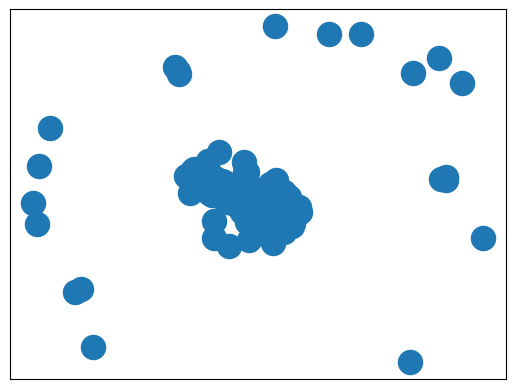

In [93]:
nx.draw_networkx(Training_graph, with_labels = False)

adding node 0
adding node 1
adding node 2
adding node 3
adding node 4
adding node 5
adding node 6
adding node 7
adding node 8
adding node 9
adding node 10
adding node 11
adding node 12
adding node 13
adding node 14
adding node 15
adding node 16
adding node 17
adding node 18
adding node 19
adding node 20
adding node 21
adding node 22
adding node 23
adding node 24
adding node 25
adding node 26
adding node 27
adding node 28
adding node 29
adding node 30
adding node 31
adding node 32
adding node 33
adding node 34
adding node 35
adding node 36
adding node 37
adding node 38
adding node 39
adding node 40
adding node 41
adding node 42
adding node 43
adding node 44
adding node 45
adding node 46
adding node 47
adding node 48
adding node 49
adding node 50
adding node 51
adding node 52
adding node 53
adding node 54
adding node 55
adding node 56
adding node 57
adding node 58
adding node 59
adding node 60
adding node 61
adding node 62
adding node 63
adding node 64
adding node 65
adding node 66
addin

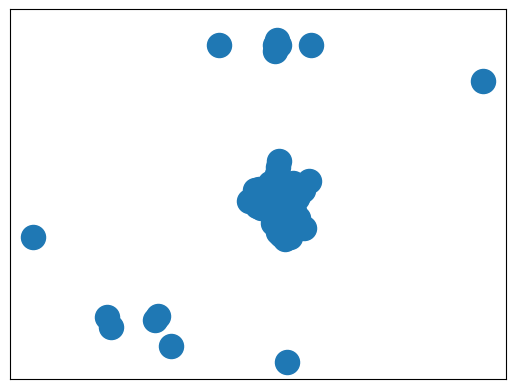

In [94]:
Training_graph = nx.Graph()

for i in range(len(df_train)):
    print('adding node',i)
    Training_graph.add_node(i)
    for j in range(i):
        if euclid(df_train.iloc[j]['embeddings'], df_train.iloc[i]['embeddings']) <= 61.07:      #così in media ogni nodo è collegato al 2% degli altri nodi, in media
            Training_graph.add_edge(i,j)

pickle.dump(Training_graph, open('all_lvl_graph_Level_.02.pickle', 'wb'))
nx.draw_networkx(Training_graph, with_labels = False)

adding node 0
adding node 1
adding node 2
adding node 3
adding node 4
adding node 5
adding node 6
adding node 7
adding node 8
adding node 9
adding node 10
adding node 11
adding node 12
adding node 13
adding node 14
adding node 15
adding node 16
adding node 17
adding node 18
adding node 19
adding node 20
adding node 21
adding node 22
adding node 23
adding node 24
adding node 25
adding node 26
adding node 27
adding node 28
adding node 29
adding node 30
adding node 31
adding node 32
adding node 33
adding node 34
adding node 35
adding node 36
adding node 37
adding node 38
adding node 39
adding node 40
adding node 41
adding node 42
adding node 43
adding node 44
adding node 45
adding node 46
adding node 47
adding node 48
adding node 49
adding node 50
adding node 51
adding node 52
adding node 53
adding node 54
adding node 55
adding node 56
adding node 57
adding node 58
adding node 59
adding node 60
adding node 61
adding node 62
adding node 63
adding node 64
adding node 65
adding node 66
addin

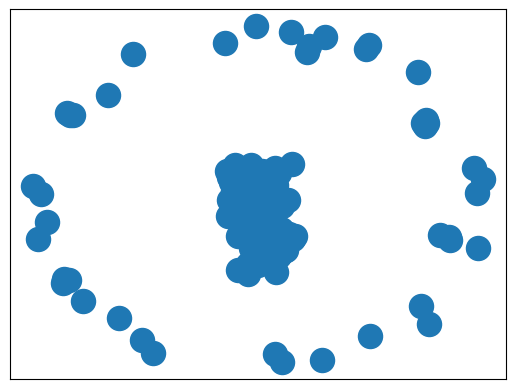

In [95]:
Training_graph = nx.Graph()

for i in range(len(df_train)):
    print('adding node',i)
    Training_graph.add_node(i)
    for j in range(i):
        if euclid(df_train.iloc[j]['embeddings'], df_train.iloc[i]['embeddings']) <= 53.82:      #così in media ogni nodo è collegato al .5% degli altri nodi, in media
            Training_graph.add_edge(i,j)

pickle.dump(Training_graph, open('all_lvl_graph_Level_.005.pickle', 'wb'))
nx.draw_networkx(Training_graph, with_labels = False)